In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import git
import seaborn as sns
import nltk
import re
import urlextract
import unicodedata
import sklearn.metrics as metrics
%matplotlib inline

from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import KeyedVectors

In [216]:
repo_url = "https://github.com/roneysco/Fake.br-Corpus.git"

if not os.path.exists("fake_br"):
    repo = git.Repo.clone_from(repo_url, "fake_br")

In [217]:
folder = r'fake_br/full_texts/'

In [218]:
def extract_data(data_path, label):
    dir_data = glob(data_path + label + '/*.txt')
    array = []

    # Capturando dados das notícias
    for path in tqdm(dir_data):
        with open(path, encoding='utf-8') as file:
            text = file.read()
        array.append([text, label])   
         
    return array

In [219]:
fake_news = extract_data(folder, 'fake')
true_news = extract_data(folder, 'true')
fake_br = np.array(fake_news + true_news)

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [220]:
def preprocessing(database):
    data = database[:, 0]
    label = database[:, 1]

    stopwords = set(nltk.corpus.stopwords.words("portuguese"))
    pattern_words = re.compile(r'\b[\w-]+\b')
    extractor = urlextract.URLExtract()
    preprocessed_texts = []

    for text in tqdm(data):
        text = text.lower()
        text = re.sub(r'["\']', '', text)
        text = ''.join(c for c in unicodedata.normalize('NFC', text) if unicodedata.category(c) != 'Mn')
        text = ' '.join([word for word in text.split() if not extractor.has_urls(word)])
        tokens = pattern_words.findall(text)
        tokens = [token for token in tokens if token not in stopwords and token.isalpha()]
        preprocessed_texts.append(' '.join(tokens))

    return preprocessed_texts, label


In [221]:
news, y = preprocessing(fake_br)

  0%|          | 0/7200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news)
encoded_texts = tokenizer.texts_to_sequences(news)

vocab_size = len(tokenizer.word_index) + 1
max_length = 1000
batch_size = 32
# embedding_dims = 100

In [ ]:
X = pad_sequences(encoded_texts, maxlen = max_length, padding = 'post')
X.shape

(7200, 1000)

In [ ]:
def word_vec_matrix(embedding, word_index, vocabulary_size, embedding_dims):
    
    # embedding = KeyedVectors.load_word2vec_format(embedding_path, encoding = 'utf-8')
    word_vector_matrix = np.zeros((vocabulary_size, embedding_dims))

    for word, index in word_index.word_index.items():
        vector = None

        if word in embedding:
            vector = embedding.get_vector(word)

        if vector is not None:
            word_vector_matrix[index] = vector
        else:
            print(word)
    
    return word_vector_matrix

In [ ]:
if 'glove_path' not in globals(): 
    glove_path = r'glove\glove_s100.txt'

glove = KeyedVectors.load_word2vec_format(glove_path, encoding = 'utf-8')
word_vector_matrix = word_vec_matrix(glove, tokenizer, vocab_size, 100)

costamarques
tillerson
haisem
galloro
mendherson
rodrimar
gerum
àquela
sailson
àqueles
pinera
queermuseu
foloni
àquele
skripal
thaméa
caguaripano
guillier
chebar
tobé
colunadoestadao
palen
alexya
dopaz
barrêto
rivasplata
warao
deusdina
schute
cleyber
lakdim
sylvino
colunadoestadão
gétero
umanizzare
terraplanistas
manobr
goyases
livianu
benningfield
laniele
asmaislidas
shayrat
heiderich
lighthizer
mancilia
cofig
cancellier
colombeck
fakeapp
gópi
anffa
pelella
recy
astrini
hallawell
trespach
hypersoft
luleco
luchsinger
kosel
chirikova
sheikhoun
coogal
balestreri
huveneers
facemedia
zilbovicius
sfoggia
deepfakes
àquelas
almasri
redmusic
omertà
carlesse
khafif
sologamia
últ
couv
abdouni
felberg
fanb
cardiomed
scheidel
joler
radioacidentados
morillot
cardozão
oglobo
àquilo
helley
paramacay
lorotário
iskin
abativa
prodeic
setebrasil
kotronakis
carainho
aprimoramemto
gaiote
carrazzone
autocasamento
matanuska
funfir
esú
partiurs
femmenino
traywick
franaszek
bríggida
budeikin
thae
ifcn
kevinho


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

In [223]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)

In [224]:
# mm = MinMaxScaler()

# X_train = mm.fit_transform(X_train)
# X_test = mm.transform(X_test)

In [225]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.2, stratify = y_train)

In [237]:
filters = 200
kernel_size = 8
hidden_dims = 50
epochs = 3

In [238]:
def create_model():
    vec_size = 100

    model = Sequential()

    model.add(Embedding(vocab_size, 
                        vec_size, 
                        input_length = max_length, 
                        weights = [word_vector_matrix], 
                        trainable = False))
    # model.add(Dropout(0.2))

    model.add(Conv1D(filters, 
                     kernel_size, 
                     padding = 'valid',
                     activation = 'relu'))

    model.add(MaxPooling1D())
    # model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(hidden_dims, activation = 'relu'))
    # model.add(Dropout(0.2))

    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = Adam(learning_rate = 0.0001), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])

    # callbacks = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1)
    # es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 10)
    
    return model

In [239]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 10)
model = create_model()

hist_adam = model.fit(X_train, y_train,
                      batch_size = batch_size,
                      epochs = epochs, 
                      validation_data = (X_val, y_val),
                      callbacks = [es])

test_acc = model.evaluate(X_test,  y_test)

Epoch 1/3
144/144 [==============================] - 4s 22ms/step - loss: 0.2365 - accuracy: 0.9164 - val_loss: 0.1535 - val_accuracy: 0.9566
Epoch 2/3
144/144 [==============================] - 3s 18ms/step - loss: 0.1249 - accuracy: 0.9547 - val_loss: 0.1210 - val_accuracy: 0.9618
Epoch 3/3
45/45 [==============================] - 0s 10ms/step - loss: 0.1072 - accuracy: 0.9625


In [240]:
pred = (model.predict(X_test) > 0.5).astype('int32')
text_prob = model.predict(X_test)

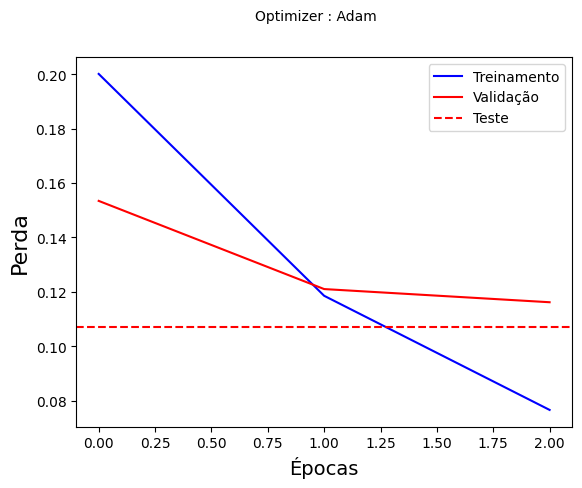

In [241]:
#plotting Train
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Perda', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.plot(hist_adam.history['loss'], color='b', label='Treinamento')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validação')
plt.axhline(test_acc[0], color='r',linestyle='dashed',label='Teste')
# plt.plot(hist_adam.history['accuracy'], color='g', label='Training Accuracy')
# plt.plot(hist_adam.history['val_accuracy'], color='y', label='Validation Accuracy')
plt.legend(loc='upper right')

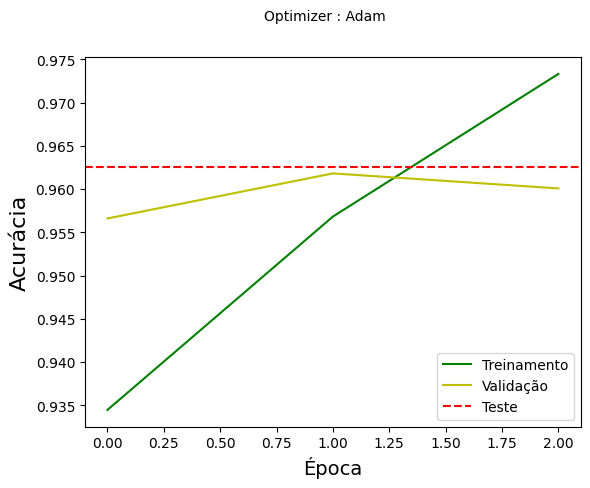

In [242]:
#plotting Test
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Acurácia', fontsize=16)
plt.xlabel('Época', fontsize=14)
# plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
# plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.plot(hist_adam.history['accuracy'], color='g', label='Treinamento')
plt.plot(hist_adam.history['val_accuracy'], color='y', label='Validação')
plt.axhline(test_acc[1], color='r',linestyle='dashed',label='Teste')
plt.legend(loc='lower right')

In [243]:
print("Accuracy:", metrics.accuracy_score(y_test, pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, pred))

print("F1 Score:",metrics.f1_score(y_test, pred))

Accuracy: 0.9625
Precision: 0.9663865546218487
Recall: 0.9583333333333334
F1 Score: 0.9623430962343097


<AxesSubplot: >

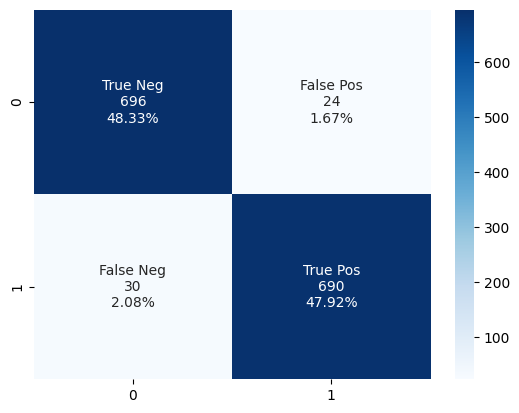

In [244]:
cm = confusion_matrix(y_test, pred).astype('int32')

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')